In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
# We use models.Model which is the same as keras.Model
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [3]:
# load data
X_test = np.load("project_data/project/X_test.npy")
y_test = np.load("project_data/project/y_test.npy")
person_train_valid = np.load("project_data/project/person_train_valid.npy")
X_train_valid = np.load("project_data/project/X_train_valid.npy")
y_train_valid = np.load("project_data/project/y_train_valid.npy")
person_test = np.load("project_data/project/person_test.npy")

In [4]:
# adjust label values
y_train_valid -= 769
y_test -= 769

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [6]:
'''
# split into train and validation set. Assumes iid
perm = np.random.permutation(X_train_valid.shape[0])
numTrain = int(0.8*X_train_valid.shape[0])
numVal = X_train_valid.shape[0] - numTrain
Xtrain = X_train_valid[perm[0:numTrain]]
ytrain = y_train_valid[perm[0:numTrain]]
Xval = X_train_valid[perm[numTrain: ]]
yval = y_train_valid[perm[numTrain: ]]
'''

'\n# split into train and validation set. Assumes iid\nperm = np.random.permutation(X_train_valid.shape[0])\nnumTrain = int(0.8*X_train_valid.shape[0])\nnumVal = X_train_valid.shape[0] - numTrain\nXtrain = X_train_valid[perm[0:numTrain]]\nytrain = y_train_valid[perm[0:numTrain]]\nXval = X_train_valid[perm[numTrain: ]]\nyval = y_train_valid[perm[numTrain: ]]\n'

In [7]:

def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:500]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

# random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = to_categorical(y_test_prep, 4)

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_valid.shape)
print (y_valid.shape)


(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
(6960, 250, 1, 22)
(6960, 4)
(1772, 250, 1, 22)
(1772, 4)
(1500, 250, 1, 22)
(1500, 4)


In [8]:
def Ksquare(x):
    return tf.pow(x, 2)
def Klog(x):
    return tf.math.log(x)

In [9]:
'''
#w/out data aug: 0.4953464620994137
#Simple CNN w/ data aug, Test accuracy:  0.5948081016540527
model = Sequential()
model.add(layers.Input((22,1000)))
model.add(layers.Reshape((22,1000,1)))
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(Dense(4, activation='softmax'))
'''

"\n#w/out data aug: 0.4953464620994137\n#Simple CNN w/ data aug, Test accuracy:  0.5948081016540527\nmodel = Sequential()\nmodel.add(layers.Input((22,1000)))\nmodel.add(layers.Reshape((22,1000,1)))\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Flatten())\nmodel.add(Dense(4, activation='softmax'))\n"

In [10]:
'''
#Deeper CNN w/ data aug, Test accuracy:  0.6495485305786133
#Deeper CNN w/out data aug, Test accuracy: 0.53052216409576864
model = Sequential()
model.add(layers.Input((22,1000)))
model.add(layers.Reshape((22,1000,1)))
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(Dense(4, activation='softmax'))
'''

"\n#Deeper CNN w/ data aug, Test accuracy:  0.6495485305786133\n#Deeper CNN w/out data aug, Test accuracy: 0.53052216409576864\nmodel = Sequential()\nmodel.add(layers.Input((22,1000)))\nmodel.add(layers.Reshape((22,1000,1)))\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Flatten())\nmodel.add(Dense(4, activation='softmax'))\n"

In [11]:
'''
#Shallow CNN-GRU: Test accuracy:  0.44695258140563965
#w/ data aug: Test accuracy:  0.6151241660118103
model = Sequential()
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(80, kernel_size=(10,1), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(160, kernel_size=(10,1), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Reshape((5, 1*160)))
model.add(layers.GRU(12, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))
'''

"\n#Shallow CNN-GRU: Test accuracy:  0.44695258140563965\n#w/ data aug: Test accuracy:  0.6151241660118103\nmodel = Sequential()\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu', input_shape=(250,1,22)))\nmodel.add(MaxPooling2D(pool_size=(3,1), padding='same'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(80, kernel_size=(10,1), activation='elu'))\nmodel.add(MaxPooling2D(pool_size=(3,1), padding='same'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(160, kernel_size=(10,1), activation='elu'))\nmodel.add(MaxPooling2D(pool_size=(3,1), padding='same'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Reshape((5, 1*160)))\nmodel.add(layers.GRU(12, recurrent_dropout=0.5))\nmodel.add(Dense(4, activation='softmax'))\n"

In [12]:

#Shallow CNN-LSTM: Test accuracy:  0.44695258140563965
#w/ data aug: Test accuracy:  0.6608352065086365
model = Sequential()
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(80, kernel_size=(10,1), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(160, kernel_size=(10,1), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Reshape((5, 1*160)))
model.add(layers.LSTM(12, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))


In [13]:
'''
#Shallow CNN-LSTM (Credit to Tonmoy (slightly changed)): Test accuracy:  0.6890519261360168
model = Sequential()
model.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(80, kernel_size=(10,1), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(160, kernel_size=(10,1), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense((50)))
model.add(layers.Reshape((50,1)))
model.add(layers.LSTM(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1)))
model.add(Dense(4, activation='softmax'))
'''

"\n#Shallow CNN-LSTM (Credit to Tonmoy (slightly changed)): Test accuracy:  0.6890519261360168\nmodel = Sequential()\nmodel.add(layers.Conv2D(40, kernel_size=(10,1), activation='elu', input_shape=(250,1,22)))\nmodel.add(MaxPooling2D(pool_size=(3,1), padding='same'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(80, kernel_size=(10,1), activation='elu'))\nmodel.add(MaxPooling2D(pool_size=(3,1), padding='same'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Conv2D(160, kernel_size=(10,1), activation='elu'))\nmodel.add(MaxPooling2D(pool_size=(3,1), padding='same'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense((50)))\nmodel.add(layers.Reshape((50,1)))\nmodel.add(layers.LSTM(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1)))\nmodel.add(Dense(4, activation='softmax'))\n"

In [14]:
#model = models.Model(inputs=inputs, outputs=outputs, name='shallow_convnet')
model.compile(keras.optimizers.Adam(), 'categorical_crossentropy', metrics=['acc'])
#model.compile(keras.optimizers.Adam(), keras.losses.SparseCategoricalCrossentropy(), 
#             metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 241, 1, 40)        8840      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 81, 1, 40)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 1, 40)         160       
_________________________________________________________________
dropout (Dropout)            (None, 81, 1, 40)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 1, 80)         32080     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 1, 80)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 1, 80)         3

In [16]:
loss_hist = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 50, verbose=True)

Epoch 1/50
218/218 [==============================] - 5s 21ms/step - loss: 1.3551 - acc: 0.3318 - val_loss: 1.2840 - val_acc: 0.4000
Epoch 2/50
218/218 [==============================] - 5s 21ms/step - loss: 1.2661 - acc: 0.4118 - val_loss: 1.1978 - val_acc: 0.4600
Epoch 3/50
218/218 [==============================] - 4s 20ms/step - loss: 1.1851 - acc: 0.4731 - val_loss: 1.1428 - val_acc: 0.5087
Epoch 4/50
218/218 [==============================] - 4s 20ms/step - loss: 1.1256 - acc: 0.5180 - val_loss: 1.0682 - val_acc: 0.5567
Epoch 5/50
218/218 [==============================] - 4s 20ms/step - loss: 1.0706 - acc: 0.5519 - val_loss: 0.9909 - val_acc: 0.5933
Epoch 6/50
218/218 [==============================] - 4s 20ms/step - loss: 1.0349 - acc: 0.5682 - val_loss: 0.9624 - val_acc: 0.6120
Epoch 7/50
218/218 [==============================] - 4s 20ms/step - loss: 0.9772 - acc: 0.5994 - val_loss: 0.9002 - val_acc: 0.6393
Epoch 8/50
218/218 [==============================] - 4s 20ms/step - 

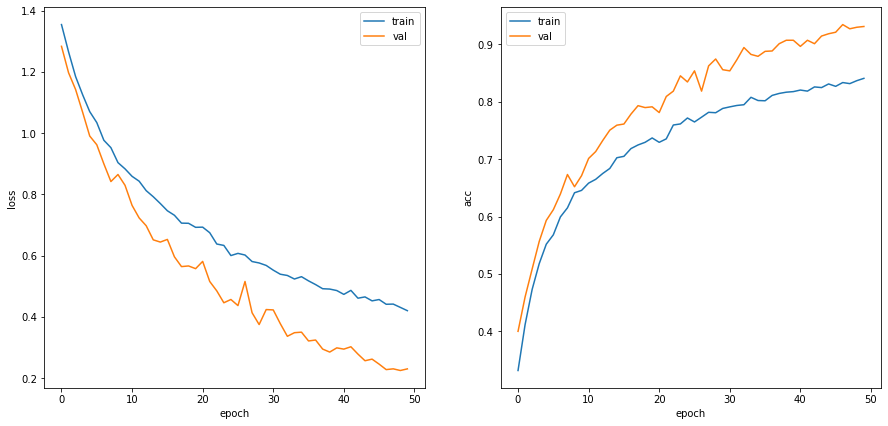

In [17]:
hist = loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", score[1])

Test accuracy:  0.6224604845046997
